# SOAM FLOW RUN QUICKSTART

In the following notebook we present a simple quickstart to expose how to make a connection with a database, extract the data, transform it, generate a forecast, plot it and send a mail report using soam modules and methods in simple steps by using our soam flow.

In [1]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from muttlib.dbconn import get_client
import pandas as pd
from soam.workflow import Transformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from soam.workflow.forecaster import Forecaster
from soam.models import SkProphet
from soam.utilities.utils import add_future_dates
import matplotlib.pyplot as plt
from soam.reporting import mail_report
import datetime
from soam.core import SoamFlow
from prefect import task

Importing plotly failed. Interactive plots will not work.


## Extraction
DB Connection using `muttlib`. <br>
`SQL Query` constructed <br>
`SOAM Extractor` object initialization.

In [2]:
pg_cfg = {
    "host": "localhost",
    "port": 5432,
    "db_type": "postgres",
    "username": "mutt",
    "password": "mutt",
    "database": "sqlalchemy"
}
pg_client = get_client(pg_cfg)[1]

In [5]:
build_query_kwargs={
    'columns': '*',
    'timestamp_col': 'date',
    'start_date': "2021-03-01",
    'end_date': "2021-03-20",
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'order_by': ["date ASC"]
}

In [ ]:
extractor = TimeSeriesExtractor(db=pg_client, table_name='stocks_valuation')

## Preprocessing
`SOAM Transformer` object initialization. <br>
Tasks created upon functions based on custom transformations.

In [23]:
scaler = MinMaxScaler()
ts = Transformer(transformer = scaler)

@task()
def transform_df_for_scaler(df = df):
    data = np.array([df.avg_price])
    data = np.swapaxes(data, 0, 1)
    return data

@task()
def transform_df_format(df = df):    
    df = df[['date', 'avg_price']]
    df.rename(columns = {
        'date': 'ds',
        'avg_price': 'y'}, inplace = True)
    df.ds =  pd.to_datetime(df.ds, infer_datetime_format=True)
    df = add_future_dates(df, periods=7, frequency="d")
    return df

## Forecasting
Forecasting model selected: `FBProphet`. <br>
`SOAM Forecaster` object initialization.

In [27]:
my_model = SkProphet(weekly_seasonality=False, daily_seasonality=False)
forecaster = Forecaster(my_model, output_length=7)

## Postprocessing
Postprocessing tasks based on functions for custom transformations.

In [37]:
@task(nout=2)
def post_processing(df = df, predictions = predictions):
    dfp = df
    dfp["ds"] = dfp["ds"].dt.strftime("%d")
    dfp = dfp.set_index("ds")

    predp = predictions
    predp["ds"] = predp["ds"].dt.strftime("%d")
    predp =  predp.set_index("ds")
    return dfp, predp

## Plotting and Reporting
Plotting task based on a function to generate a custom `time-series` plot.

In [44]:
@task()
def plot_results(dfp = dfp, predp = predp):
    # construct the plot
    fig = plt.figure(figsize=(18,7))
    plt.plot(dfp.index, dfp.y, marker='o', color='black', label="History")
    plt.plot(predp.index, predp.yhat, marker='o', color='purple', linestyle='dashed', label="Forecast")
    
    # legend title and labels
    plt.legend(loc='best')
    plt.title(
        "Normalized Average Price of Apple's Stock Value Time Series for March of 2021", 
        fontdict = {
            'fontsize': '20',
            'fontweight' : '300',
            'verticalalignment': 'baseline'
            })
    plt.ylabel('Normalized average price', fontdict = {'fontsize': '15'})
    plt.xlabel('Day of month', fontdict = {'fontsize': '15'})

    # save and show fig
    plt.savefig('img/applestockprice.png')
    plt.show()

`SOAM Mail Report` object initialization.

In [48]:
mr = mail_report.MailReportTask(
    # recipients mails separated by commas
    mail_recipients_list = ["mail@gmail.com"],
    # the metric name will be in the title
    metric_name = "Stocks Forecast" 
)

# SoamMFlow

Putting all together using `SoaMFlow`.

In [55]:
with SoamFlow(name = "t") as t:
    # EXTRACTION
    df = extractor(build_query_kwargs)
    # PRE PROCESSING
    data = transform_df_for_scaler(df = df)
    df.avg_price = ts(data)[0]
    df = transform_df_format(df = df)
    # FORECASTING
    predictions, time_series, model = forecaster(time_series=df)
    # POST PROCESSING
    dfp, predp = post_processing(df = df, predictions = predictions)
    # PLOTTING
    plot_results(dfp = dfp, predp = predp)
    # REPORTING
    mr(current_date = "2021-05-06", plot_filename = "img/applestockprice.png")

[2021-04-06 23:56:16-0300] INFO - prefect.FlowRunner | Beginning Flow run for 't'
INFO:prefect.FlowRunner:Beginning Flow run for 't'
[2021-04-06 23:56:16-0300] INFO - prefect.TaskRunner | Task 'TimeSeriesExtractor': Starting task run...
INFO:prefect.TaskRunner:Task 'TimeSeriesExtractor': Starting task run...
[2021-04-06 23:56:16-0300] INFO - prefect.TaskRunner | Task 'TimeSeriesExtractor': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'TimeSeriesExtractor': Finished task run for task with final state: 'Success'
[2021-04-06 23:56:16-0300] INFO - prefect.TaskRunner | Task 'transform_df_format': Starting task run...
INFO:prefect.TaskRunner:Task 'transform_df_format': Starting task run...
[2021-04-06 23:56:16-0300] INFO - prefect.TaskRunner | Task 'transform_df_format': Finished task run for task with final state: 'Success'
/home/scafati98/MUTT/soam/quickstart_env/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value i

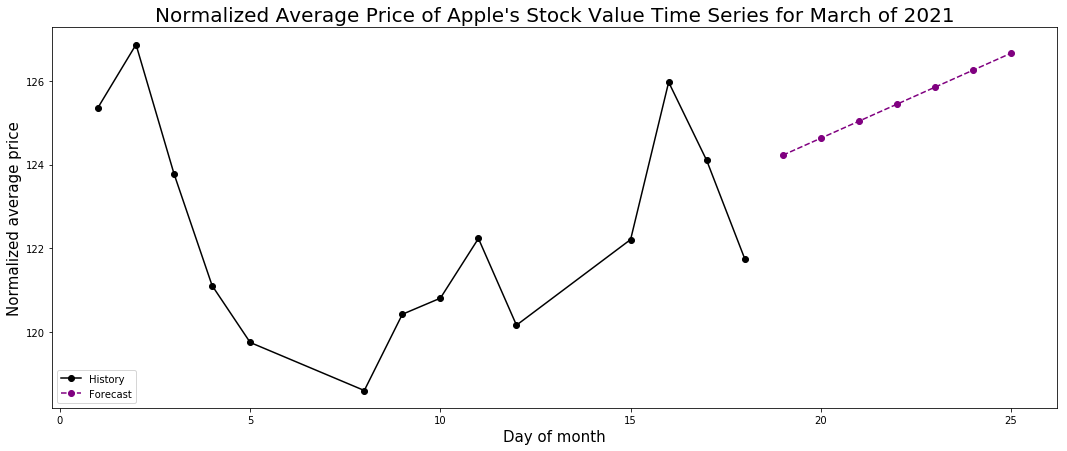

[2021-04-06 23:56:50-0300] INFO - prefect.TaskRunner | Task 'plot_results': Finished task run for task with final state: 'Success'
INFO:prefect.TaskRunner:Task 'plot_results': Finished task run for task with final state: 'Success'
[2021-04-06 23:56:50-0300] INFO - prefect.FlowRunner | Flow run SUCCESS: all reference tasks succeeded
INFO:prefect.FlowRunner:Flow run SUCCESS: all reference tasks succeeded


<Success: "All reference tasks succeeded.">

In [56]:
t.run()